# Домашнее задание 5: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def entropy(distribution: list[float]) -> float:
    """
    :distribution: распределение вероятностей из каждого класса
    :return: возвращает энтропию системы
    """
    return -1 * sum([p_i * np.log(p_i) for p_i in distribution])

p_k1 = 8/10
p_k2 = 2/10
print(f'Entropy 10 объектов = {round(entropy(distribution=[p_k1, p_k2]), 2)}')

Entropy 10 объектов = 0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [3]:
def gini(R, class_):
    """
    Индекс Джини
    :R: количество точек
    :class_: список классов, попавших в лист
    :return: возвращает индекс Джини
    """
    distribution = [number/R for number in class_]
    return sum([p_i*(1-p_i) for p_i in distribution])

def information_gain(l: int, r: int, R_m: int, **class_):
    ginileft = gini(R=l, class_=class_['lclass'])
    giniright = gini(R=r, class_=class_['rclass'])
    gini0 = gini(R_m, class_=class_['lclass']+class_['rclass'])
    return gini0 - l/R_m*ginileft - r/R_m*giniright
    
information_gain(l=8, r=2, R_m=10, lclass=[8], rclass=[2])
#information_gain(l=13, r=7, R_m=20, lclass=[5, 8], rclass=[6, 1])

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [4]:
predict = np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
predict

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [5]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [6]:
def gain_regression(y_left: np.ndarray, y_right: np.ndarray, y_leaf: np.ndarray) -> float:
    """ 
    Функция рассчитыает прирост информации, как ошибку разбиения 
    по формуле: H_left*(l_size/leaf_size) + H_right*(r_size/leaf_size), где 
        * l_size - сколько объектов попало в левую часть.
        * r_size - сколько объектов попало в правую часть.
        * leaf_size - сколько объектов было в листе до разбиения
        * H_left - дисперсия таргета для левого подлиста
        * H_right - дисперсия таргета для левого подлиста
    """
    leaf_size = y_left.shape[0] + y_right.shape[0]
    l_size = y_left.shape[0]
    r_size = y_right.shape[0]
    
    # H = y_leaf.std()**2 # для полной формулы прироста информации 
    H_left = y_left.std()**2
    H_right = y_right.std()**2
    
    return H_left * l_size/leaf_size + H_right * r_size/leaf_size

# измененная версия information_gain
def gini(R, class_):
    """
    Индекс Джини
    :R: количество точек
    :class_: словарь классов, попавших в лист
    :return: возвращает индекс Джини
    """
    distribution = [number/R for _, number in class_.items()] # надеюсь, с этим циклом проблем не будет, он к перебору порогов не относится
    return sum([p_i*(1-p_i) for p_i in distribution])

def gain_classification(y_left: np.ndarray, y_right: np.ndarray, y_leaf: np.ndarray) -> float:
    """ 
    Функция рассчитыает прирост информации для классификации, как ошибку разбиения 
    по формуле: ginileft*(l_size/leaf_size) + giniright*(r_size/leaf_size), где 
        * l_size - сколько объектов попало в левую часть.
        * r_size - сколько объектов попало в правую часть.
        * leaf_size - сколько объектов было в листе до разбиения
        * ginileft - gini левого подлиста
        * giniright - gini правого подлиста
    """
    l_size = len(y_left)
    l_class = Counter(y_left)
    r_size = len(y_right)
    r_class = Counter(y_right)
    leaf_size = len(y_leaf)
    
    ginileft = gini(R=l_size, class_=l_class)
    giniright = gini(R=r_size, class_=r_class)
    # gini0 = gini(R_m, class_=class_['lclass']+class_['rclass']) # для полной формулы прироста информации 
    
    return ginileft * l_size/leaf_size + giniright * r_size/leaf_size

In [175]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    
    Усреднение соседних элементов:
     - В качестве X и y поступают уже отсортированные массивы. В самом начале мы берем каждую пару объектов
    В X выборке и target выборке и усредняем их, то есть: X = [20, 10, 5, 4], y = [9, 8, 3, 4]. После усреднения
    получим: X = [15, 10], y = [36, 6]. Алгоритм перебирает пороги по усредненным X, y.
    
    Реализация разбиения:
     - Функция реализована на функции map() и векторов для перебора порогов.
    Идея заключается в том, что с помощью map() мы будем применять функцию get_gain() 
    для вектора enum_vector = [1, 2, ..., len(X)]. Каждый раз из вектора enum_vector
    мы будем доставать все новое и новое число, это число и будем служить разбиением.
    Первое число, которые мы достаем, это 1, следовательно, разбиение будет таким:
    [0], [1, 2, 3, ..., len(X)] - нулевой объект из X - здесь является порогом.
    В левую часть уходит только он, в правую же часть уходят все остальные объекты
    из X. Второе число из enum_vector - это 2, следовательно, разбиение будет таким:
    [0, 1], [2, 3, ..., len(X)]. Теперь уже первый объект из выборки X становится порогом
    и в левую часть уйдут два объекта, а в правую остальные. При каждом разбиение мы считаем gain.
    
    Реализация feature_type:
     - Функция способна принимать как числовые признаки, так и категориальные. 
    Управление реализуется в самом начале алгоритма и внутри функции get_gain.
    И там, и там применяются условия. Если feature_type == 'real', то
    происходит усреднение X и y, как было описано выше. Если же feature_type == 'categorical',
    тогда в качестве порогов, мы берем уникальные значения из X.
    Например, X = ['красный', 'красный', 'желтый'] тогда unique_X = ['красный', 'желтый'].
    Перебирая unique_X, алгоритм получает gain значения.
    """
    assert len(feature_vector) == len(target_vector), ('Кол-во объектов в feature_vector != кол-ву объектов в target_vector')

    def get_gain(x: int) -> float:
        """
        Функция рассчитывает прирост информации, согласно задачи: регрессия/классификация
        :param x: число из вектора enum_vector
        :return: gain - критерий информативности, как ошибка разбиения
        """
        gain_choice = {
            "classification": gain_classification,
            "regression": gain_regression
        }
        if feature_type == 'real':
            slice_left = np.arange(x) # разбиение в левую часть
            slice_right = np.arange(x, enum_vector.shape[0]+1) # разбиение в правую часть
            y_left, y_right = y[slice_left], y[slice_right]
            
        if feature_type == 'categorical':
            y_left, y_right = data[data['X'] == x].y, data[data['X'] != x].y
            
        gain = gain_choice[task](y_left, y_right, y)
        return gain
    
    def get_average_thresholds_x(x: int) -> float:
        """
        :param x: число из вектора enum_vector
        :return: среднее значение соседних элементов по признаку
        """
        avg = sum(X[x-2:x])/2
        return avg
    
    def get_average_thresholds_y(x: int) -> float:
        """
        :param x: число из вектора enum_vector
        :return: среднее значение соседних элементов по таргету
        """
        avg = sum(y.iloc[x-2:x])/2
        return avg
    
    
    X = feature_vector.copy()
    y = target_vector.copy()
    
    if feature_type == 'real':
        enum_vector = np.arange(2, len(X), step=2) # вектор для усреднения соседних элементов по X
        X = np.array(list(map(get_average_thresholds_x, enum_vector))) # признак X уменьшеный в два раза
        enum_vector = np.arange(2, len(y), step=2) # вектор для усреднения соседних элементов по y
        y = np.array(list(map(get_average_thresholds_y, enum_vector))) # признак y уменьшеный в два раза
    
        enum_vector = np.arange(1, len(X)) # вектор для перебора порогов
        variances = np.array(list(map(get_gain, enum_vector))) # массив из gain по каждому разбиению
        variance_best = np.min(variances) # оптимальный gain
    
        threshold_best = X[np.argmin(variances)] # оптимальный порог
        thresholds = X[np.arange(variances.shape[0])] # вектор возможных порогов
    
    if feature_type == 'categorical':
        unique_X = np.unique(X) # работаем только с вектором из уникальных значений признака
        data = pd.DataFrame(data={'X': X, 'y': y}) # соединяем в df, чтобы легче отделать объекты, data.X == 'красный'
        
        variances = np.array(list(map(get_gain, unique_X))) # массив из gain по каждому уникальному категориальному значению
        variance_best = np.min(variances) # оптимальный gain
        
        thresholds = unique_X # вектор из возможных порогов
        threshold_best = thresholds[np.argmin(variances)] # оптимальный порог 
        
    return thresholds, variances, threshold_best, variance_best
        
    
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["CRIM"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Эту функцию можно протестировать на датасете `Boston` из `sklearn`.

In [174]:
from sklearn.datasets import load_boston

boston = load_boston()
X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = pd.Series(boston["target"], name='target')

data = pd.concat((X, y), axis=1)
data.sort_values(by='CRIM', inplace=True)
X = data.drop('target', axis=1)
y = data['target']

print(boston["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

/home/yunost/Desktop/github/data-analysis-handbook/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `CRIM`.

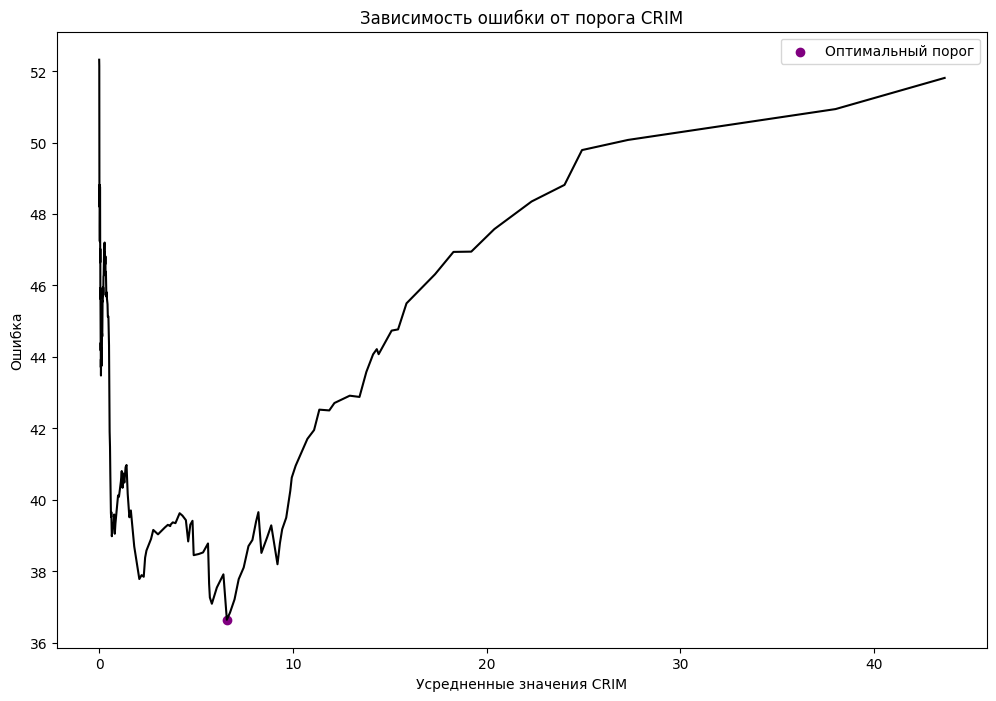

In [176]:
plt.figure(figsize=(12, 8))
plt.title('Зависимость ошибки от порога CRIM')
plt.ylabel('Ошибка')
plt.xlabel('Усредненные значения CRIM')
plt.scatter(threshold_best, variance_best, label='Оптимальный порог', c='purple')
plt.legend()
plt.plot(thresholds, variances, c='black')
plt.show()

Сгенерируем данные для классификации

In [177]:
X = np.random.randint(0, 100, size=100)
X.sort()
y = (X > 50).astype('int64')
y[:30:2] = 1
y = pd.Series(y)

In [178]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X, 
    y, 
    task="classification",
    feature_type="real"
)

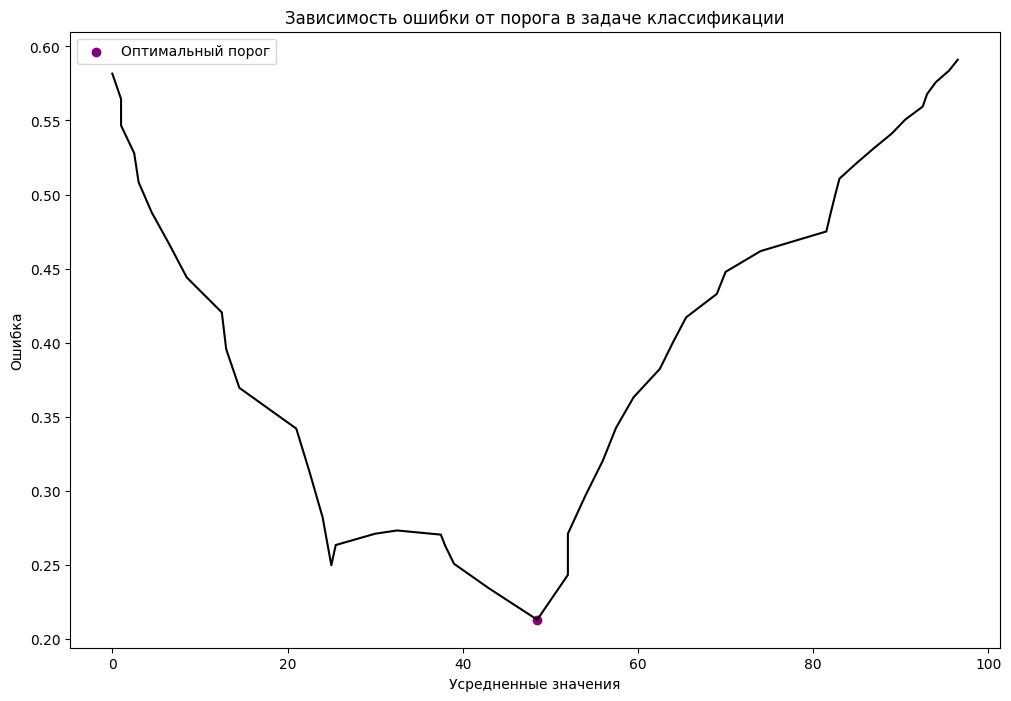

In [179]:
plt.figure(figsize=(12, 8))
plt.title('Зависимость ошибки от порога в задаче классификации')
plt.ylabel('Ошибка')
plt.xlabel('Усредненные значения')
plt.scatter(threshold_best, variance_best, label='Оптимальный порог', c='purple')
plt.legend()
plt.plot(thresholds, variances, c='black')
plt.show()

Протестируем функцию на категориальный признак

In [180]:
colors = {'белый': 0,
          'черный': 1,
          'зеленый': 2,
          'розовый': 3,
          'голубой': 4,
          'оранжевый': 5,
          'синий': 6,
          'желтый': 7}

colors_list = [(color, number) for color, number in colors.items()]
random_colors = np.random.choice(range(len(colors_list)), size=1000)

X_color = []
y_color = []
for i in random_colors:
    X_color.append(colors_list[i][0])
    y_color.append(colors_list[i][1])
    
print(X_color)
print(y_color)

['синий', 'черный', 'зеленый', 'розовый', 'зеленый', 'желтый', 'зеленый', 'желтый', 'синий', 'голубой', 'синий', 'черный', 'розовый', 'синий', 'розовый', 'голубой', 'оранжевый', 'желтый', 'синий', 'голубой', 'синий', 'розовый', 'оранжевый', 'голубой', 'синий', 'синий', 'голубой', 'голубой', 'оранжевый', 'розовый', 'розовый', 'черный', 'желтый', 'синий', 'оранжевый', 'оранжевый', 'желтый', 'синий', 'зеленый', 'голубой', 'белый', 'голубой', 'розовый', 'синий', 'зеленый', 'голубой', 'оранжевый', 'белый', 'оранжевый', 'черный', 'розовый', 'розовый', 'оранжевый', 'розовый', 'розовый', 'белый', 'розовый', 'оранжевый', 'оранжевый', 'розовый', 'розовый', 'белый', 'зеленый', 'оранжевый', 'зеленый', 'синий', 'синий', 'синий', 'голубой', 'черный', 'розовый', 'белый', 'черный', 'белый', 'зеленый', 'белый', 'желтый', 'белый', 'синий', 'зеленый', 'розовый', 'желтый', 'зеленый', 'зеленый', 'розовый', 'оранжевый', 'голубой', 'оранжевый', 'белый', 'голубой', 'розовый', 'оранжевый', 'оранжевый', 'голубо

In [181]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    np.array(X_color), 
    np.array(y_color), 
    task="classification",
    feature_type="categorical"
)

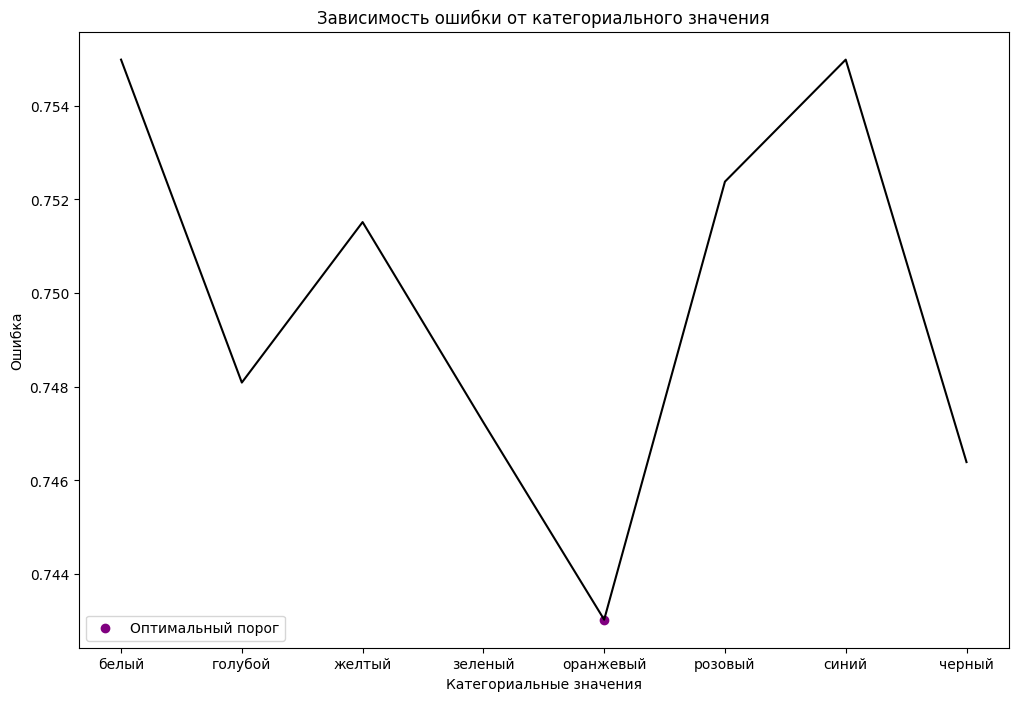

In [182]:
plt.figure(figsize=(12, 8))
plt.title('Зависимость ошибки от категориального значения')
plt.ylabel('Ошибка')
plt.xlabel('Категориальные значения')
plt.plot(thresholds, variances, c='black')
plt.scatter(threshold_best, variance_best, label='Оптимальный порог', c='purple')
plt.legend()
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        # ᕕ(╭ರ╭ ͟ʖ╮•́)⊃¤=(————-
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Посмотрим на распределение целевой переменной

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?